# Chapter 14

## Setup and imports

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from collections import namedtuple

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt

In [4]:
nhefs_all = pd.read_excel('NHEFS.xls')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
nhefs_all.shape

(1629, 64)

Add `'constant'`, dummy variables, and squared variables, as done in previous chapters

In [6]:
nhefs_all['censored'] = nhefs_all.wt82.isnull().astype('int')

In [7]:
nhefs_all['constant'] = 1

In [8]:
edu_dummies = pd.get_dummies(nhefs_all.education, prefix='edu')
exercise_dummies = pd.get_dummies(nhefs_all.exercise, prefix='exercise')
active_dummies = pd.get_dummies(nhefs_all.active, prefix='active')

nhefs_all = pd.concat(
    [nhefs_all, edu_dummies, exercise_dummies, active_dummies],
    axis=1
)

In [9]:
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    nhefs_all['{}^2'.format(col)] = nhefs_all[col] * nhefs_all[col]

Subset the data as described in the margin, pg 11.

In [10]:
restriction_cols = [
    'sex', 'age', 'race', 'wt82', 'ht', 'school', 'alcoholpy', 'smokeintensity'
]
missing = nhefs_all[restriction_cols].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]

In [11]:
nhefs.shape

(1566, 81)

## Section 14.3

### Program 14.1

"In our smoking cessation example, we will use the nonstabilized IP weights $W^C = 1 \, / \, \Pr[C = 0|L,A]$ that we estimated in Chapter 12. Again we assume that the vector of variables is sufficient to adjust for both confounding and selection bias." pg 34

In [12]:
X_ip = nhefs_all[[
    'constant',
    'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2',
    'qsmk'
]]

We can reuse a function from chapter 12 to help us create IP weights

In [13]:
def logit_ip_f(y, X):
    """
    Create the f(y|X) part of IP weights
    from logistic regression
    
    Parameters
    ----------
    y : Pandas Series
    X : Pandas DataFrame
    
    Returns
    -------
    Numpy array of IP weights
    
    """
    model = sm.Logit(y, X)
    res = model.fit()
    weights = np.zeros(X.shape[0])
    weights[y == 1] = res.predict(X.loc[y == 1])
    weights[y == 0] = 1 - res.predict(X.loc[y == 0])
    return weights

In [14]:
weights = 1 / logit_ip_f(nhefs_all.censored, X_ip)

Optimization terminated successfully.
         Current function value: 0.142836
         Iterations 8


In [15]:
ip_censor = weights[nhefs_all.censored == 0]

In [16]:
print('   min     mean      max')
print('------------------------')
print('{:>6.2f}   {:>6.2f}   {:>6.2f}'.format(
    ip_censor.min(),
    ip_censor.mean(),
    ip_censor.max()
))

   min     mean      max
------------------------
  1.00     1.04     1.82


## Section 14.4

Still Program 14.1

"all individuals can be ranked according to the value of their observed outcome Y"

In [17]:
ranked = nhefs.sort_values('wt82_71', ascending=False)

In [18]:
ranked[['seqn', 'wt82_71']][:2]

,seqn,wt82_71
1366,23522,48.538386
259,6928,47.511303


In [19]:
ranked[['seqn', 'wt82_71']][-1:]

,seqn,wt82_71
1328,23321,-41.28047


## Section 14.5

### Program 14.2

"In our smoking cessation example, we first computed each individual’s value of the 31 candidates ..."

We're going to need a few different things from the regressions, wo we'll first create a container that holds that information together.

We'll want
1. absolute value of the coefficient (the basis of comparison),
2. the value of the coefficient
3. the value of psi that produced the coefficient, and
4. the p-value (for finding the 95% confidence interval)

In [20]:
GInfo = namedtuple('GInfo', ['abs_alpha', 'alpha', 'psi', 'pvalue'])

Now we'll create a function that will perform the regression and return the info we need

In [21]:
def logit_g_info(psi, data, y, X_cols, weights):
    """
    Return logistic regression parameters to identify best `psi`
    
    Note: this is written specifically for the problem in this program
    
    Paramters
    ---------
    psi : float
    data : Pandas DataFrame
        needs to contain the given `X_cols`
    y : Pandas Series or Numpy array
    X_cols : list of strings
        column names for `X`
    weights : Pandas Series or Numpy array
    
    Returns
    -------
    GInfo namedtuple, containing
    - absolute value of H_of_psi coefficient
    - H_of_psi coefficient
    - psi value
    - p-value for H_of_psi coefficient
    
    """
    data['H_of_psi'] = data.wt82_71 - psi * data.qsmk
    X = data[X_cols]
    
    gee = sm.GEE(y, X, groups=data.seqn, weights=weights, family=sm.families.Binomial())
    res = gee.fit()
    
    alpha = res.params.H_of_psi
    pvalue = res.pvalues.H_of_psi
    return GInfo(abs(alpha), alpha, psi, pvalue)

For all uses here, `y` and the `X` columns are the same.

In [22]:
y = nhefs.qsmk
X_cols = [
    'constant',
    'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2',
    'H_of_psi'
]

We'll run the regression once for the known right answer

In [23]:
g_info = logit_g_info(3.446, nhefs, y, X_cols, ip_censor)

In [24]:
print('psi: {}  regression coefficient: {:>0.2g}'.format(g_info.psi, g_info.alpha))

psi: 3.446  regression coefficient: -1.9e-06


Now we'll do the course-grained search for $\psi$

In [25]:
psi_vals = np.arange(2.0, 5.0, 0.1)

In [26]:
g_info = [
    logit_g_info(psi, nhefs, nhefs.qsmk, X_cols, ip_censor)
    for psi in psi_vals
]

In [27]:
# by default, `min` will minimize the first value,
# which in this case is the absolute value of the coefficient
best = min(g_info) 

In [28]:
print('best psi: {:>0.4f}  best alpha: {:>0.5f}'.format(best.psi, best.alpha))

best psi: 3.4000  best alpha: 0.00086


The plot below shows $p$-value as a function of $psi$, with a red line at 0.05.

To find the 95% confidence interval, we find the last values that are below the line, coming from the left and the right.

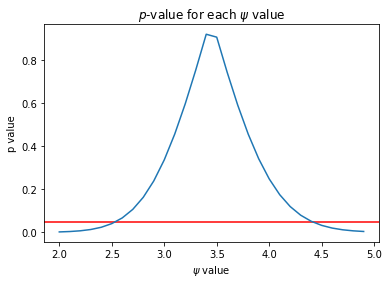

In [29]:
fig, ax = plt.subplots()

ax.axhline(0.05, c='r')
ax.plot(psi_vals, [g.pvalue for g in g_info])
ax.set_xlabel('$\psi$ value')
ax.set_ylabel('p value')
ax.set_title('$p$-value for each $\psi$ value');

In [30]:
cutoff = 0.05
ci_lo = max([g.psi for g in g_info[:len(g_info)//2] if g.pvalue < cutoff])
ci_hi = min([g.psi for g in g_info[len(g_info)//2:] if g.pvalue < cutoff])

print('95% confidence interval: ({:>0.2f}, {:>0.2f})'.format(ci_lo, ci_hi))

95% confidence interval: (2.50, 4.50)


We can use automatic function optimization to find a more exact $\psi$.

The second cell below can take a while to run.

In [31]:
def just_abs_alpha(psi):
    g_info = logit_g_info(psi, nhefs, nhefs.qsmk, X_cols, ip_censor)
    return g_info.abs_alpha

In [32]:
scipy.optimize.minimize(
    fun=just_abs_alpha,
    x0=4.0
)

      fun: 1.24222378940667e-10
 hess_inv: array([[  3.96249076e-07]])
      jac: array([ 0.00212993])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 267
      nit: 2
     njev: 85
   status: 2
  success: False
        x: array([ 3.4458988])

## Section 14.6

### Program 14.3

We can solve for $\psi$ directly. From Technical Point 14.2, we have

$$
\hat\psi = \frac{
    \sum_{i=1}^{N} W_i^C Y_i\left( A_i - \mathrm{E}[A|L_i]\right)
}{
    \sum_{i=1}^{N} W_i^C A_i\left( A_i - \mathrm{E}[A|L_i]\right)
},
$$

where the sum is over the uncensored observations, $W^C$ is the IP weights, $Y$ is `wt82_71`, $A$ is `qsmk`, and $\mathrm{E}[A|L_i]$ is the predicted `qsmk` from the model below.

In [33]:
A = nhefs.qsmk
X = nhefs[[
    'constant',
    'sex', 'race', 'age', 'age^2', 'edu_2', 'edu_3', 'edu_4', 'edu_5',
    'smokeintensity', 'smokeintensity^2', 'smokeyrs', 'smokeyrs^2', 
    'exercise_1', 'exercise_2', 'active_1', 'active_2', 'wt71', 'wt71^2',
]]

In [34]:
glm = sm.GLM(
    A,
    X,
    freq_weights=ip_censor,
    family=sm.families.Binomial()
)
res = glm.fit()

In [35]:
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
constant,-2.4029,1.314,-1.829,0.067,-4.978,0.172
sex,-0.5137,0.150,-3.422,0.001,-0.808,-0.219
race,-0.8609,0.206,-4.178,0.000,-1.265,-0.457
age,0.1152,0.049,2.328,0.020,0.018,0.212
age^2,-0.0008,0.001,-1.478,0.140,-0.002,0.000
edu_2,-0.0289,0.193,-0.150,0.881,-0.407,0.349
edu_3,0.0877,0.173,0.507,0.612,-0.252,0.427
edu_4,0.0664,0.266,0.249,0.803,-0.455,0.588
edu_5,0.4711,0.221,2.130,0.033,0.038,0.904
smokeintensity,-0.0783,0.015,-5.271,0.000,-0.107,-0.049


Using the equation at the top of this section, $\hat{\psi}$ is calculated as below

In [36]:
A_pred = res.predict(X)
Y = nhefs.wt82_71

estimate = (
    (ip_censor * Y * (A - A_pred)).sum() /
    (ip_censor * A * (A - A_pred)).sum()
)

In [37]:
estimate

3.445898803370686

"If $\psi$ is D-dimensional..."

The following is a direct translation of what's in the R and Stata code examples

In [38]:
diff = A - A_pred
diff2 = ip_censor * diff

In [39]:
lhs = np.array([
    [
        (A * diff2).sum(),
        (A * nhefs.smokeintensity  * diff2).sum()
    ],
    [
        (A * nhefs.smokeintensity * diff2).sum(), 
        (A * nhefs.smokeintensity**2 * diff2).sum()
    ]
])

lhs

array([[    292.07618742,    5701.54685801],
       [   5701.54685801,  153044.85432636]])

In [40]:
rhs = np.array([
    [(Y * diff2).sum()],
    [(Y * nhefs.smokeintensity * diff2).sum()]
])

rhs

array([[  1006.46498472],
       [ 20901.0679999 ]])

In [41]:
psi = np.linalg.solve(lhs,rhs)
psi

array([[ 2.85947039],
       [ 0.03004128]])